In [1]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import numpy as np
import scipy as sp
import seaborn as sn
import pandas as pd
from scipy.io import loadmat
import matplotlib.pylab as pl
%matplotlib inline
from linescanning.utils import get_base_dir, get_file_from_substring, resample_timecourse

import os, glob
opj = os.path.join

In [2]:
from hedfpy.EDFOperator import EDFOperator
from hedfpy.HDFEyeOperator import HDFEyeOperator
from hedfpy.EyeSignalOperator import EyeSignalOperator

In [64]:
subject = 'sub-003'
eye_dir = opj(os.environ['DIR_DATA_HOME'], subject, 'ses-2', 'eye')
func_dir = opj(os.environ['DIR_DATA_HOME'], subject, 'ses-2', 'func')
model_dir = opj(os.environ['DIR_DATA_DERIV'], 'model_fitting')
# os.chdir(os.path.expanduser(opj(os.environ['DIR_DATA_HOME'], subject, 'ses-2', 'eye')))
sn.set(style="ticks")

In [49]:
edfs = glob.glob(opj(eye_dir, '*.edf'))
edfs.sort()
edfs

['/mnt/d/FSL/shared/spinoza/projects/hemifield/sub-003/ses-2/eye/sub-003_ses-2_task-LR_run-1_events.edf',
 '/mnt/d/FSL/shared/spinoza/projects/hemifield/sub-003/ses-2/eye/sub-003_ses-2_task-LR_run-2_events.edf',
 '/mnt/d/FSL/shared/spinoza/projects/hemifield/sub-003/ses-2/eye/sub-003_ses-2_task-LR_run-3_events.edf',
 '/mnt/d/FSL/shared/spinoza/projects/hemifield/sub-003/ses-2/eye/sub-003_ses-2_task-LR_run-4_events.edf']

In [50]:
low_pass_pupil_f, high_pass_pupil_f = 6.0, 0.01
ho = HDFEyeOperator(opj(eye_dir, f"{subject}_ses-2_task-LR_events.h5"))

# alias = 'test_1'

if not os.path.exists(opj(eye_dir, f"{subject}_ses-2_task-LR_events.h5")):

    for i, edf_file in enumerate(edfs):
        ho.add_edf_file(edf_file)
        ho.edf_message_data_to_hdf(alias=f'run_{i+1}')
        ho.edf_gaze_data_to_hdf(alias=f'run_{i+1}', 
                                pupil_hp=high_pass_pupil_f, 
                                pupil_lp=low_pass_pupil_f)

In [51]:
def filter_for_eyeblinks(arr,skip_time=None,filt_window=350, sample_rate=500, exp_start=None):

    """
filter_for_eyeblinks

This function reads where a blink occurred and will filter onset times with a particular window of 
occurrance. For instance, a blink generally takes about 100 ms, so any onsets within 100 ms of each
other can't be physiologically correct. The function will find the first onset time, checks for onset
times within the 100ms window using the sampling rate, and return the filtered onset times.

Arguments:
    <arr>               : np.ndarray
                        array to-be-filtered. If obtained from 'signal_during_period', use 'to_numpy()' 
                        as input

    <skip_time>        : int
                        skip the first <skip_time> seconds from sampled data to leave out any unphysio-
                        logical events (default = None)

    <filt_window>       : float
                        consider events within <filt_window> as one blink. Given in seconds, default
                        is set to 350ms (0.35s). See:
                        `https://bionumbers.hms.harvard.edu/bionumber.aspx?id=100706&ver=0`

    <sample_rate>       : int
                        sampling rate of data, used together with <filt_window> to get the amount of 
                        data points that need to be clustered as 1 event

    <exp_start>         : float
                        add the start of the experiment time to the onset times. Otherwise timing is re-
                        lative to 0, so it's not synced with the experiment.

Usage:
    eyeblinks = filter_for_eyeblinks(onsets, skip_timepoints=5000, filt_window=100, sample_rate=500)

Returns:
    <onset times>       : np.ndarray
                        numpy array containing onset times in seconds

"""

    blink_onsets = np.where(arr == 0)[0]

    blink = 0
    filter = True
    blink_arr = []
    while filter:

        try:
            start_blink = blink_onsets[blink]
            end_blink = start_blink+int((filt_window/1000*sample_rate))

            for ii in np.arange(start_blink+1, end_blink):
                if ii in blink_onsets:
                    blink_onsets = np.delete(blink_onsets, np.where(blink_onsets == ii))

            blink_arr.append(blink_onsets[blink])
            
            blink += 1
        except:
            filter = False

    onsets = np.array(blink_arr)
    onsets = onsets*(1/sample_rate)

    if skip_time:
        for pp in onsets:
            if pp < skip_time:
                onsets = np.delete(onsets,np.where(onsets==pp))

    if exp_start:
        onsets = onsets+exp_start

    return onsets

In [58]:
## Do stuff for each run

# for eyerun in np.arange(1,len(edfs)+1):
for eyerun in np.arange(3,4):

    print("\n---------------------------------------------------------------------------------")
    print(f" Dealing with run: {eyerun}")

    alias = f'run_{eyerun}'

    # load times per session:
    trial_times = ho.read_session_data(alias, 'trials')
    trial_phase_times = ho.read_session_data(alias, 'trial_phases')

    # read func data file to get nr of volumes
    func_file = get_file_from_substring("{}_bold.mat".format(alias.replace('_','-')), func_dir)
    TR = 0.105

    # read in func data to get number of samples
    raw = loadmat(func_file)
    tag = list(raw.keys())[-1]
    raw = raw[tag]

    nr_vols = raw.shape[-1]
    func_time = nr_vols*TR

    # get block parameters
    session_start_EL_time = trial_times.iloc[0,:][0]
    sample_rate = ho.sample_rate_during_period(alias)
    session_stop_EL_time = session_start_EL_time+(func_time*sample_rate) # add number of fMRI*samplerate as stop EL time

    eye = ho.eye_during_period([session_start_EL_time, session_stop_EL_time], alias)

    print(" Sample rate: ", sample_rate)
    print(" Start time:  ", session_start_EL_time)
    print(" Stop time:   ", session_stop_EL_time)

    # set some stuff required for successful plotting with seconds on the x-axis
    div = False
    if sample_rate == 500:
        n_samples = int(session_stop_EL_time-session_start_EL_time)/2
        duration_sec = n_samples*(1/sample_rate)*2

        div = True
    elif sample_rate == 1000:
        n_samples = int(session_stop_EL_time-session_start_EL_time)
        duration_sec = n_samples*(1/sample_rate)
    else:
        raise ValueError(f"Did not recognize sample_rate of {sample_rate}")

    print(" Duration:     {}s [{} samples]".format(duration_sec,n_samples))


    # Fetch a bunch of data
    pupil_raw = np.squeeze(ho.signal_during_period(time_period=[session_start_EL_time, session_stop_EL_time+1], alias=alias, signal='pupil', requested_eye=eye))
    pupil_int = np.squeeze(ho.signal_during_period(time_period=[session_start_EL_time, session_stop_EL_time+1], alias=alias, signal='pupil_int', requested_eye=eye))
    pupil_bp = np.squeeze(ho.signal_during_period(time_period=[session_start_EL_time, session_stop_EL_time+1], alias=alias, signal='pupil_bp',requested_eye=eye))
    pupil_lp = np.squeeze(ho.signal_during_period(time_period=[session_start_EL_time, session_stop_EL_time+1], alias=alias, signal='pupil_lp',requested_eye=eye))
    pupil_hp = np.squeeze(ho.signal_during_period(time_period=[session_start_EL_time, session_stop_EL_time+1], alias=alias, signal='pupil_hp',requested_eye=eye))
    pupil_bp_psc = np.squeeze(ho.signal_during_period(time_period=[session_start_EL_time, session_stop_EL_time+1], alias=alias, signal='pupil_bp_psc',requested_eye=eye))
    pupil_bp_psc_c = np.squeeze(ho.signal_during_period(time_period=[session_start_EL_time, session_stop_EL_time+1], alias=alias, signal='pupil_bp_clean_psc',requested_eye=eye))

    # Do some plotting
    if not div:
        x = np.arange(0,duration_sec,(1/sample_rate))
    else:
        x = np.arange(0,duration_sec,(1/(sample_rate/2)))

    # resample to match functional data
    resamp = resample_timecourse(pupil_bp_psc_c, n_samples=nr_vols)
    resamp1 = resample_timecourse(pupil_raw, n_samples=nr_vols)

    # add start time to it
    start_exp_time = trial_times.iloc[0,:][-1]
    print(" Start time exp = ", round(start_exp_time,2))

    # get onset time of blinks, cluster blinks that occur within 350 ms
    onsets = filter_for_eyeblinks(pupil_raw.to_numpy(), skip_time=10, filt_window=500, sample_rate=sample_rate, exp_start=start_exp_time)
    
    # normal eye blink is 1 blink every 4 seconds, throw warning if we found more than a blink per second
    # ref: https://www.sciencedirect.com/science/article/abs/pii/S0014483599906607
    blink_rate = len(onsets) / duration_sec

    print(" Found {} blinks [{} blinks per second]".format(len(onsets), round(blink_rate,2)))

    if blink_rate > 1 or blink_rate < 0.1:
        print(f" WARNING: found {round(blink_rate,2)} blinks per second; normal blink rate is 0.25 blinks per second")

    print(" Saving blink onsets times and pupil size trace")
    np.save(opj(func_dir, '{}_ses-2_task-LR_{}_eyeblinks.npy'.format(subject, alias.replace('_','-'))), onsets.T)
    np.save(opj(func_dir, '{}_ses-2_task-LR_{}_pupilsize.npy'.format(subject, alias.replace('_','-'))), resamp)

    print(" Done")


---------------------------------------------------------------------------------
 Dealing with run: 3
 Sample rate:  1000
 Start time:   8057507.0
 Stop time:    8393507.0
 Duration:     336.0s [336000 samples]
 Start time exp =  25.64
 Found 54 blinks [0.16 blinks per second]
 Saving blink onsets times and pupil size trace
 Done


In [59]:
pupil_int.shape

(336000,)

<ipython-input-65-f1e959657f8e>:34: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig(os.path.join(model_dir, subject, 'ses-2', f'{subject}_ses-2_desc-eyetrack.png'), transparant=True)
/home/gjheij/.local/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/gjheij/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:134: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


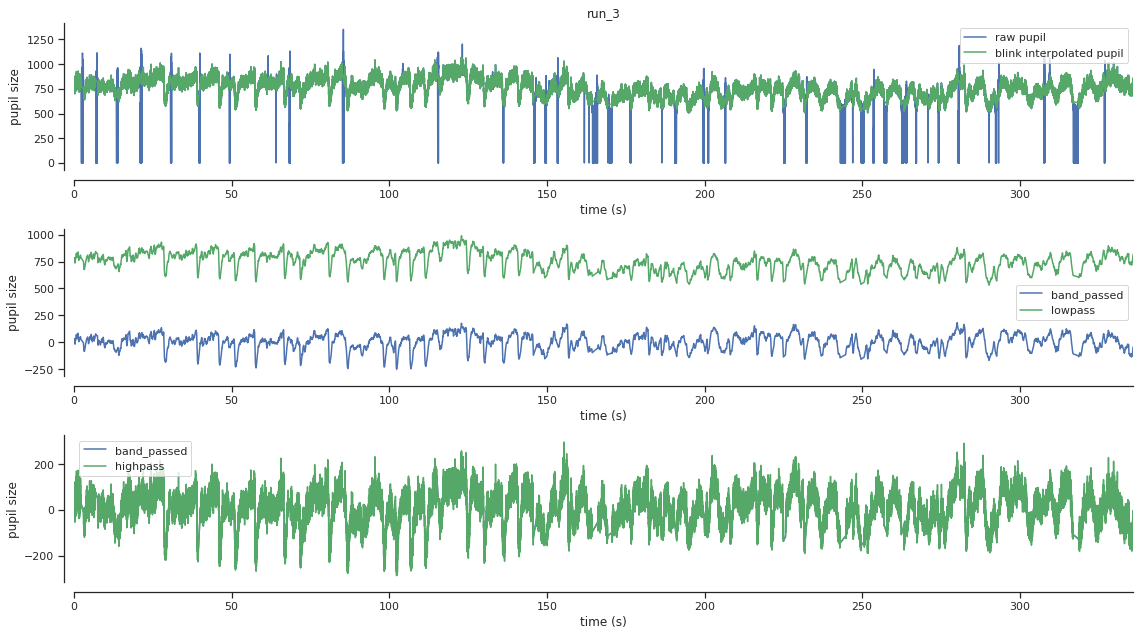

In [65]:
# plot interpolated pupil:

if sample_rate == 500:
    x = np.arange(0, duration_sec, 1/sample_rate*2)
else:
    x = np.arange(0, duration_sec, 1/sample_rate)

fig = pl.figure(figsize = (16,9))
s = fig.add_subplot(311)
pl.plot(x, pupil_raw, 'b'); pl.plot(x, pupil_int, 'g')
pl.xlim(0,duration_sec)

pl.ylabel('pupil size'); pl.xlabel('time (s)')
pl.legend(['raw pupil', 'blink interpolated pupil'])
s.set_title(alias)
sn.despine(offset=10)

s = fig.add_subplot(312)
pl.plot(x, pupil_bp, 'b'); pl.plot(x, pupil_lp, 'g')
pl.ylabel('pupil size'); pl.xlabel('time (s)')
pl.legend(['band_passed', 'lowpass'])
sn.despine(offset=10)
pl.xlim(0,duration_sec)

s = fig.add_subplot(313)
pl.plot(x, pupil_bp, 'b'); pl.plot(x, pupil_hp, 'g')
pl.ylabel('pupil size'); pl.xlabel('time (s)')
pl.legend(['band_passed', 'highpass'])
sn.despine(offset=10)
pl.xlim(0,duration_sec)

pl.tight_layout()

fig.savefig(os.path.join(model_dir, subject, 'ses-2', f'{subject}_ses-2_desc-eyetrack.png'), transparant=True)

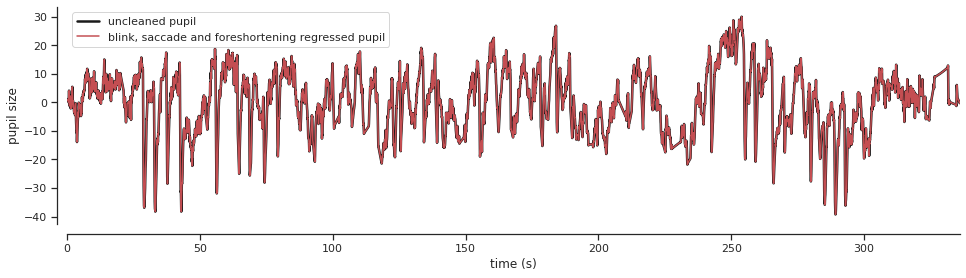

In [35]:
#
# plot the 'regress blinks' processing step, 
# which estimates the effects of blinks, saccades and foreshortening on the data
# and regresses these effects out.
#

# plot interpolated pupil:
fig = pl.figure(figsize=(16,4))
pl.plot(x, pupil_bp_psc, 'k', lw=2.5)
pl.plot(x, pupil_bp_psc_c, 'r', lw=1.5)
pl.xlim(0,duration_sec)
pl.ylabel('pupil size'); pl.xlabel('time (s)')
pl.legend(['uncleaned pupil', 'blink, saccade and foreshortening regressed pupil'])
sn.despine(offset=10)

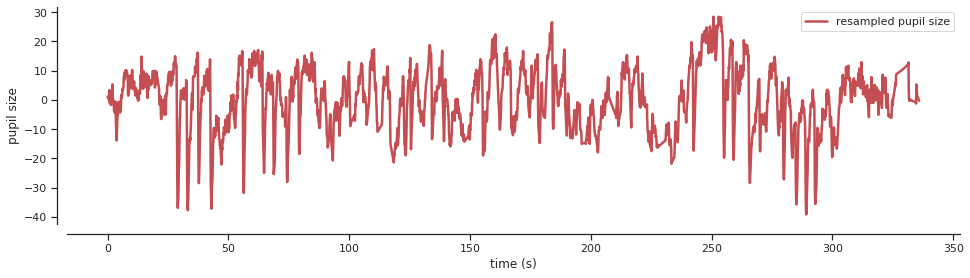

In [36]:
resamp = resample_timecourse(pupil_bp_psc_c, n_samples=nr_vols)

fig = pl.figure(figsize=(16,4))

pl.plot(np.arange(0,duration_sec,TR),resamp, 'r', lw=2.5)
pl.ylabel('pupil size'); pl.xlabel('time (s)')
pl.legend(['resampled pupil size'])
sn.despine(offset=10)

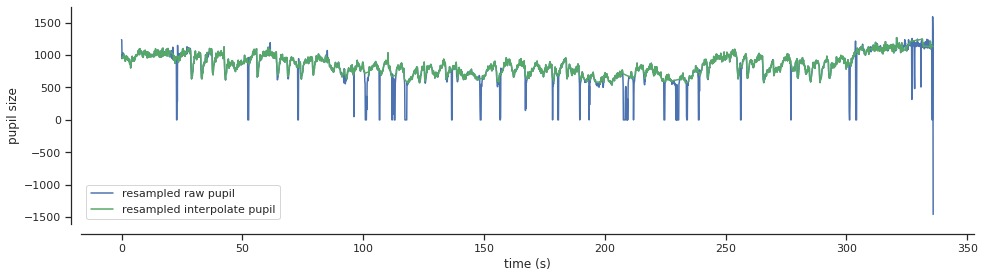

In [37]:
fig = pl.figure(figsize=(16,4))
x = np.arange(0,duration_sec,TR)
resamp1 = resample_timecourse(pupil_raw, n_samples=nr_vols)
pl.plot(x,resamp1, 'b')

resamp2 = resample_timecourse(pupil_int, n_samples=nr_vols)
pl.plot(x,resamp2, 'g')

pl.ylabel('pupil size'); pl.xlabel('time (s)')
pl.legend(['resampled raw pupil', 'resampled interpolate pupil'])
sn.despine(offset=10)